In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as sts
import warnings

from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
baslik_font = {'family': 'arial', 'color': 'darkred','weight': 'bold','size': 13 }
eksen_font  = {'family': 'arial', 'color': 'darkblue','weight': 'bold','size': 10 }

In [2]:
kidney = pd.read_csv("C:\\Users\\Gunesim\\Desktop\\Ödevler\\Proje_1\\kidney_disease.csv", engine="python", encoding="utf8")

## 1. Veriler hakkında özet bilgi
Öncelikle sütunları gözden geçirelim. Tüm sütunları görülebilmesi için tabloyu yan çevirelim.

In [3]:
kidney.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,48,7,62,48,51
bp,80,50,80,70,80
sg,1.02,1.02,1.01,1.005,1.01
al,1,4,2,4,2
su,0,0,3,0,0
rbc,NaN,NaN,normal,normal,normal
pc,normal,normal,normal,abnormal,normal
pcc,notpresent,notpresent,notpresent,present,notpresent
ba,notpresent,notpresent,notpresent,notpresent,notpresent


In [4]:
parametreler={"age":"yaş", "sg":"özgül ağırlık", "su":"şeker", "pc":"irin", 
              "ba":"bakteri", "bu":"kan üre", "sod":"sodyum", "hemo":"hemoglobin", 
              "wc":"beyaz kan sayımı", "htn":"hipertansiyon", "cad":"koroner arter",
              "pe":"pedal ödem", "bp":"tansiyon", "al":"albümin", "rbc":"kırmızı kan", 
              "pcc":"irin kümesi", "bgr":"kan şekeri", "sc":"serum kreatinin",
              "pot":"potasyum", "pcv":"paketlenmiş hücre hacmi", "rc":"kırmızı kan sayımı",
              "dm":"diabetes mellitus", "appet":"iştah", "ane":"anemi", "class":"hastalık durumu"}

### Sütunlardaki veri miktarları ve veri tipleri
Sütunlarda (özellikle bazı sütunlarda oldukça fazla) veri eksiği var. Bazı değerler de metin olarak saklanmış.

In [5]:
kidney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
id                400 non-null int64
age               391 non-null float64
bp                388 non-null float64
sg                353 non-null float64
al                354 non-null float64
su                351 non-null float64
rbc               248 non-null object
pc                335 non-null object
pcc               396 non-null object
ba                396 non-null object
bgr               356 non-null float64
bu                381 non-null float64
sc                383 non-null float64
sod               313 non-null float64
pot               312 non-null float64
hemo              348 non-null float64
pcv               330 non-null object
wc                295 non-null object
rc                270 non-null object
htn               398 non-null object
dm                398 non-null object
cad               398 non-null object
appet             399 non-null object
pe         

In [6]:
kidney.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


## 2. Veri Temizliği ve Analiz Hazırlığı
Öncelikle, metin olarak saklanan değerleri sayısal değerlere dönüştürelim. Kötü olan değerler 1, iyi olan değerler 0 olsun. Böylece, değerleri birbiri ile orantılayabilmek de mümkün olur.

In [7]:
kidney[['htn','dm','cad','pe','ane']] = kidney[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})

kidney[['rbc','pc']] = kidney[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})

kidney[['pcc','ba']] = kidney[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})

kidney[['appet']] = kidney[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})

kidney['classification'] = kidney['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})

kidney.rename(columns={'classification':'class'},inplace=True)

kidney['pe'] = kidney['pe'].replace(to_replace='good',value=0)

kidney['appet'] = kidney['appet'].replace(to_replace='no',value=0)

kidney['cad'] = kidney['cad'].replace(to_replace='\tno',value=0)

kidney['dm'] = kidney['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].replace(to_replace={'\t?':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].astype(float)

kidney.drop('id',axis=1,inplace=True)

Tablomuzdaki eksik veri miktarları aşağıda görüldüğü oldukça fazladır.

In [8]:
len(kidney)-kidney.count()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wc       106
rc       131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

#### Boş değerler
Her ne kadar büyük miktarda veri kaybına neden olsa da, bu veri setimiz için boş değerleri doldurmak uygun olmayabilir. Bu sebeple, boşlukları doldurmak yerine hesaplamadan çıkarıyoruz. Çıkardıktan sonra geriye toplam 158 verimiz kalıyor.

In [9]:
kd=kidney.dropna(axis=0)
kd_wins=kd
len(kd)

158

#### Aşırı değerler
Boxplot çizerek aşırı değerlerin mevcudiyetini kontrol edelim.

Konu sağlık olunca, uç değer kavramımızı biraz esnetmekte fayda var. Bu sebeple, boxplot'un whis değerini biraz artırarak yolumuza devam edelim.

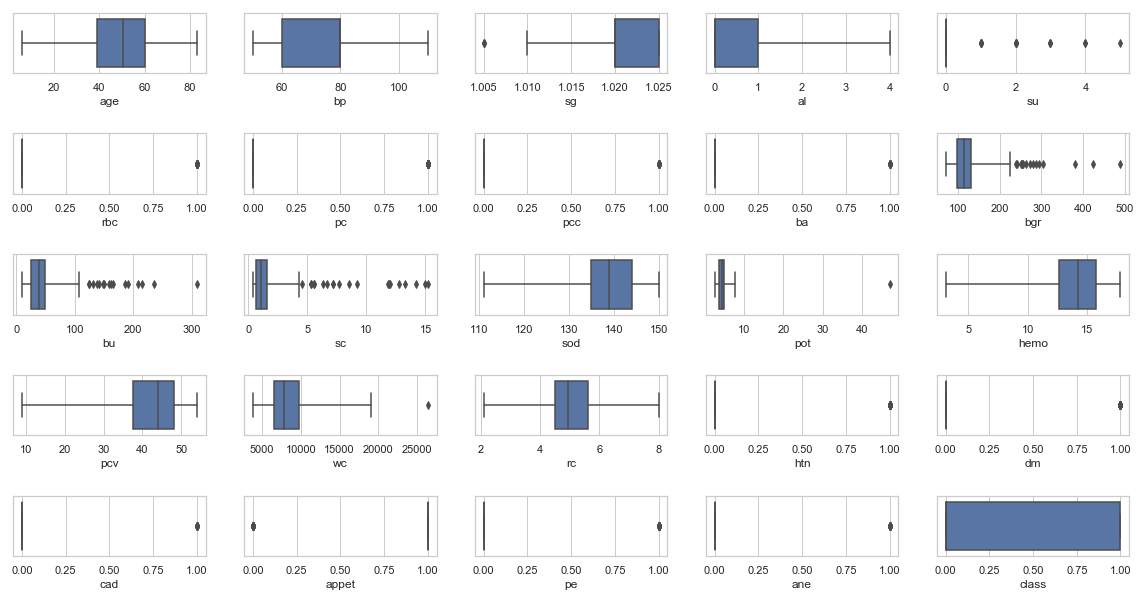

In [10]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(1,len(kd.columns)+1):
    plt.subplot(5,5,i)
    sns.boxplot(kd.iloc[:,i-1], whis=3)
plt.show()

Yukarıdaki boxplotlar incelendiğinde, 12 tane parametrede uç değerler olduğu gözlenmektedir.

Bunları winsorize edip ortadan kaldıralım. Her sütunda winsorize değerleri farklı olduğu için biz de ayrı ayrı yapalım.

In [11]:
kd_wins["sg"]=winsorize(kd_wins["sg"], (0.05, 0))
kd_wins["bgr"]=winsorize(kd_wins["bgr"], (0, 0.1))
kd_wins["bu"]=winsorize(kd_wins["bu"], (0, 0.12))
kd_wins["sc"]=winsorize(kd_wins["sc"], (0, 0.13))
kd_wins["sod"]=winsorize(kd_wins["sod"], (0.05, 0))
kd_wins["pot"]=winsorize(kd_wins["pot"], (0, 0.1))
kd_wins["hemo"]=winsorize(kd_wins["hemo"], (0.1, 0))
kd_wins["pcv"]=winsorize(kd_wins["pcv"], (0.05, 0))
kd_wins["wc"]=winsorize(kd_wins["wc"], (0, 0.08))

Winsorize işleminden sonra tekrar uç değer kontrolü yapalım. Bakalım, durum nedir?

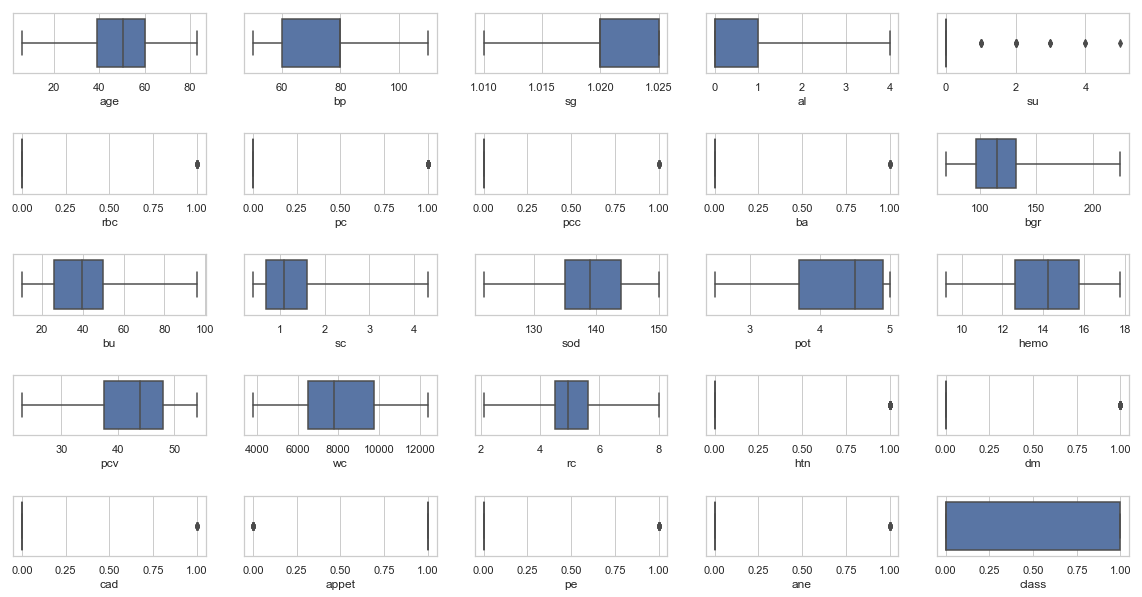

In [12]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(1,len(kd_wins.columns)+1):
    plt.subplot(5,5,i)
    sns.boxplot(kd_wins.iloc[:,i-1], whis=3)
plt.show()

Görüldüğü gibi, alt örneklemde uç değerleri kaldırdık. Şimdi, kan değerlerinin hastalıkla ilişkisine bakalım.

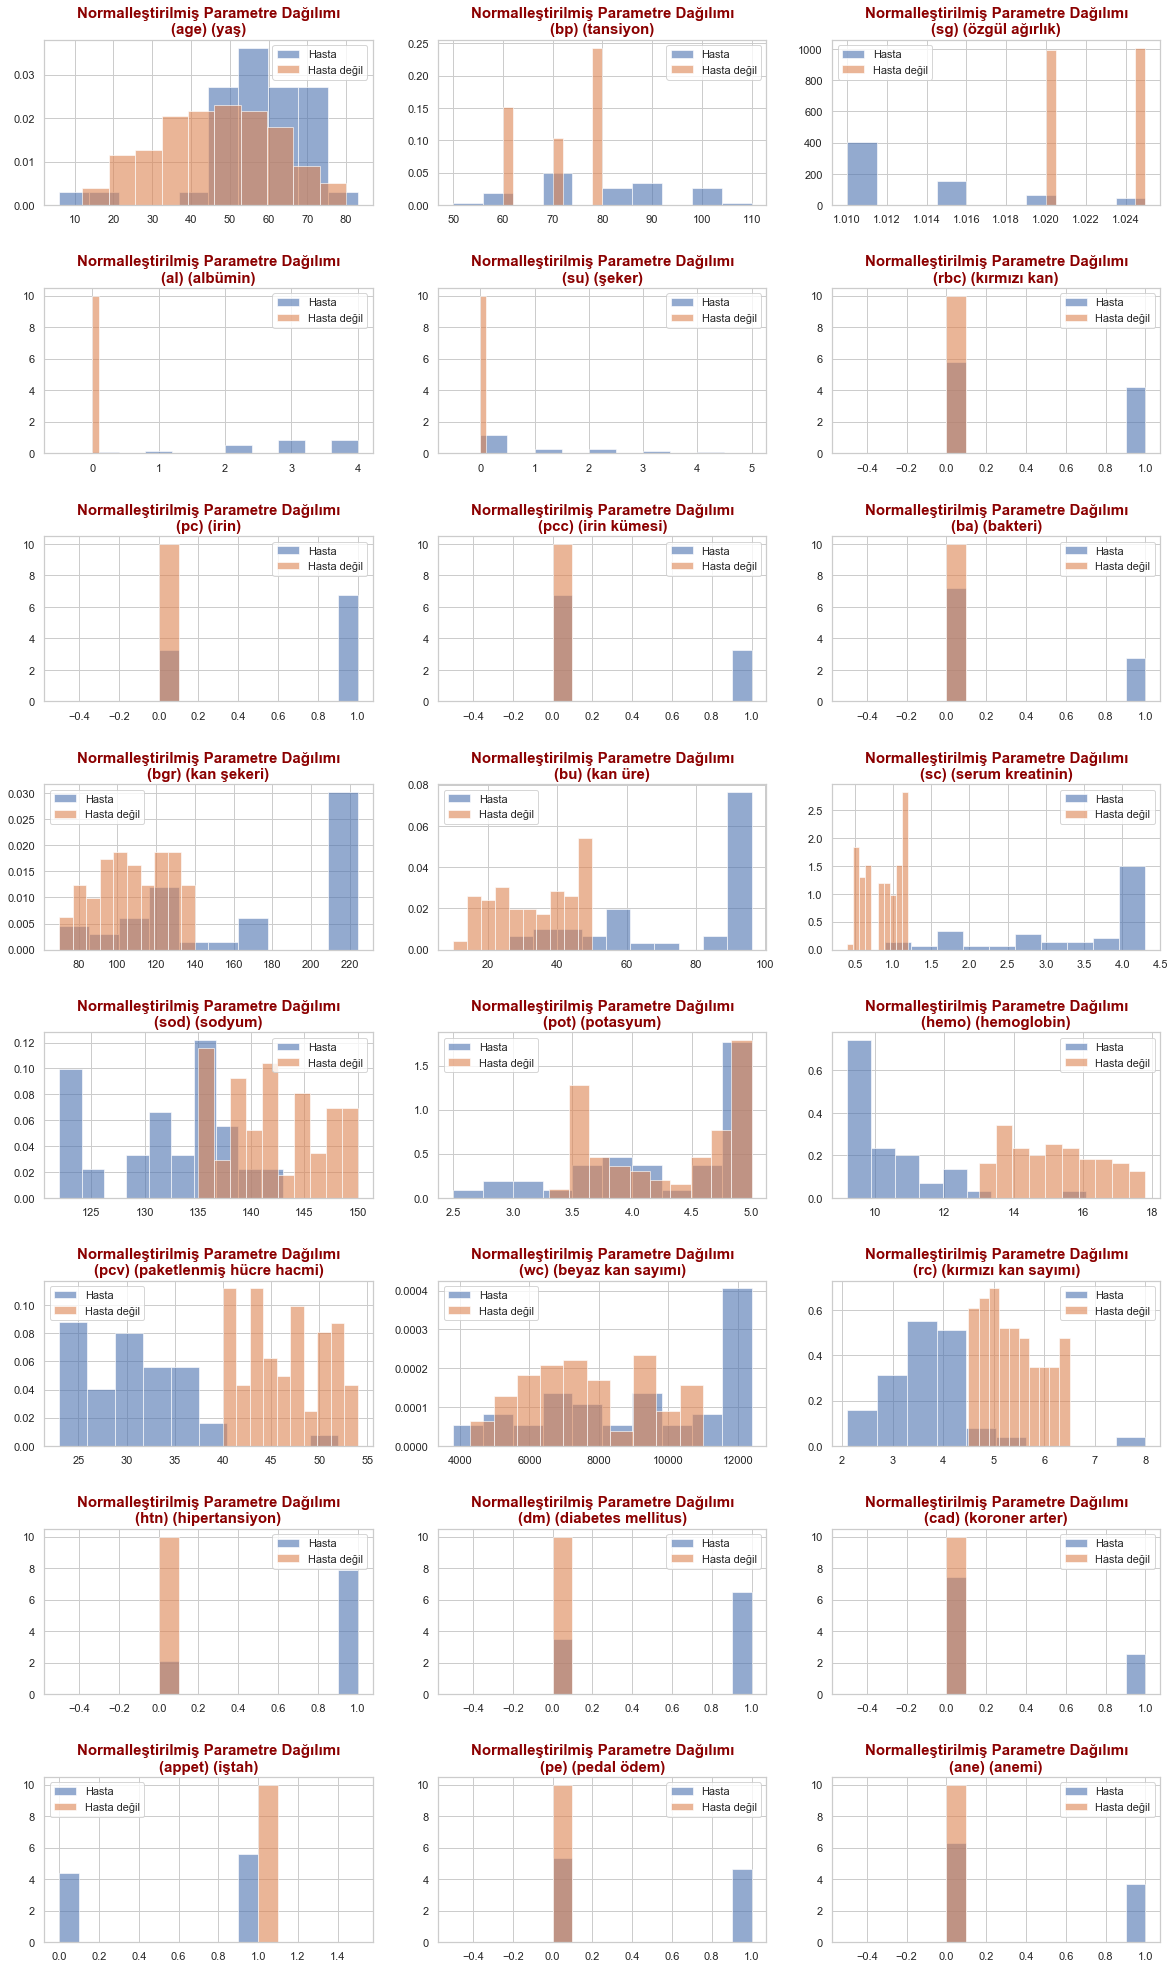

In [13]:
plt.figure(figsize=(20,35))
plt.subplots_adjust(hspace=0.5)
font_baslik={"family":"arial", "color":"darkred", "weight":"bold", "size":15}

for i in range(0, len(kd_wins.columns)-1):
    plt.subplot(8,3,i+1)
    plt.hist(kd_wins[kd_wins["class"]==1].iloc[:,i], density=True, alpha=0.6)
    plt.hist(kd_wins[kd_wins["class"]==0].iloc[:,i], density=True, alpha=0.6)
    plt.legend(["Hasta", "Hasta değil"])
    plt.ylabel
    plt.title("Normalleştirilmiş Parametre Dağılımı\n({}) ({})".format(kd_wins.columns[i], parametreler[kd_wins.columns[i]]), 
              fontdict=font_baslik)
    
plt.show()

Yukarıdaki tablolara baktığımızda;

- Hastaların yaşlarının çoğunlukla 42-72 aralığında toplandığını,

- Kan yoğunluğu, sodyum, hemoglobin, paket hücre hacmi ve kırmızı kan değerlerinin düşük olduğunu,

- Albümin, şeker, kan üre, serum kreatinin ve tansiyon değerlerinin yüksek olduğunu,

- Vücutlarında irin ve bakteriye rastlanabildiği,

- Hastalığa diabetes mellitus, koroner arter, iştahsızlık, pedal ödem, anemi sorunlarının eşlik edebildiği görülmektedir.

Bu değerler arasındaki ilişkileri daha iyi ve net anlayabilmek için bir de korelasyonlarına bakalim.

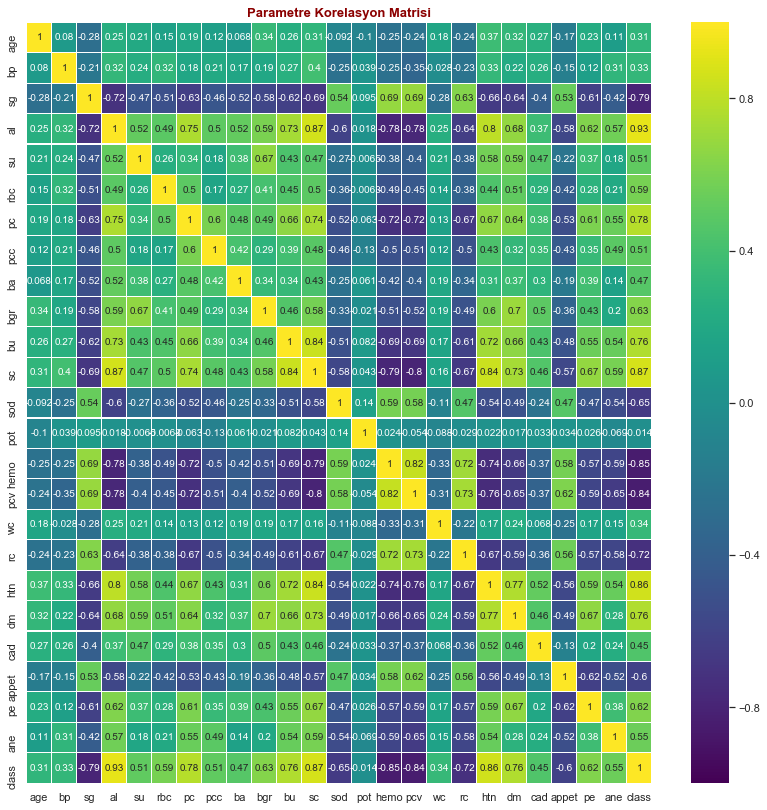

In [14]:
kd_wins_corr=kd_wins.corr()

plt.figure(figsize=(14,14))
sns.heatmap(kd_wins_corr, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)
plt.title("Parametre Korelasyon Matrisi", fontdict=baslik_font)
plt.show()

Korelasyon değerleri, yukarıda gördüğümüz histogramı büyük ölçüde doğruluyor. Korelasyon tablosunda bakıldığında yaş, bakteri mevcudiyeti ve koroner arter parametlerinin hastalıkla ilişkisi zayıf görünüyor.

Ancak, Hastalıkla;

- Albümin, irin, üre, serum kreatinin, hipertansiyon ve diabetes mellitus parametreleri arasında güçlü pozitif yönlü,

- Kan özgül ağırlığı, hemoglobin, paketlenmiş hücre hacmi ve kırmızı kan sayımı parametreleri arasında güçlü negatif yönlü ilişki mevcuttur.

Veri setimizde kaç tane özellik tutmalıyız, ona bakalım:

In [15]:
X=StandardScaler().fit_transform(kd)
Xt=X.T

Cx=np.cov(Xt)

eig_val_cov, eig_vec_cov=np.linalg.eig(Cx)

print("Özvektörler:\n-------------------------------")
print(eig_val_cov)
print("\nToplam varyansı açıklama oranı:\n-------------------------------")
print("%", ((eig_val_cov[0] + eig_val_cov[1] + eig_val_cov[2] + eig_val_cov[3] + eig_val_cov[4])/eig_val_cov.sum())*100)

Özvektörler:
-------------------------------
[12.34113001  1.70448331  1.28564542  1.13199509  1.08030674  0.94491816
  0.91259282  0.7672451   0.6886196   0.58173666  0.0312114   0.49508671
  0.06999243  0.10148538  0.44323617  0.38709718  0.39579357  0.14268956
  0.1624871   0.16979265  0.20099805  0.23292358  0.31119515  0.29620928
  0.28036457]

Toplam varyansı açıklama oranı:
-------------------------------
% 69.73010149617207


Yukarıdaki değerlere göre 5 özellik tuttuğumuzda, toplam varyansın ancak % 69.7 'sini açıklayabiliyoruz. Bizim için çok zahmetli ve verimsiz bir yol.

Bir de, PCA'yı denemekte yarar var. Bakalım sonuç nasıl değişecek?

In [16]:
sklearn_pca = PCA(n_components=4)
Y_sklearn=sklearn_pca.fit_transform(kd)

sklearn_pca.explained_variance_ratio_

array([9.99432441e-01, 3.95530830e-04, 9.43680471e-05, 4.12295144e-05])

Böbrek hastalığı ile ilgili toplam varyansın % 99.9'u sadece ilk bileşen tarafından açıklanabilmektedir.

Bizim açımızdan iyi bir haber!.. :)